# NICE for calibration

In [1]:
import sys
import random
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Input

from utils.ops import onehot_encode, optim_temperature
from utils.metrics import neg_log_likelihood
from utils.visualization import plot_pdf_triplex, plot_prob_triplex
from flows.nice import AddCouplingLayer, MLP
from calibrators import PAVCalibrator

In [2]:
%matplotlib inline

## Define NICE flow

In [3]:
input_dim = 3
activation='relu'
hidden_size = [5, 5]

### Coupling functions

In [4]:
m1 = MLP(input_dim//2, input_dim - input_dim//2, activation=activation, hidden_size=hidden_size)
m2 = MLP(input_dim - input_dim//2, input_dim//2, activation=activation, hidden_size=hidden_size)
m3 = MLP(input_dim//2, input_dim - input_dim//2, activation=activation, hidden_size=hidden_size)
m4 = MLP(input_dim - input_dim//2, input_dim//2, activation=activation, hidden_size=hidden_size)

Instructions for updating:
Colocations handled automatically by placer.


### Forward flow 

In [5]:
inp = Input(shape=(input_dim,))

x = AddCouplingLayer(m1)(inp)
x = AddCouplingLayer(m2, mode='even')(x)
x = AddCouplingLayer(m3)(x)
x = AddCouplingLayer(m4, mode='even')(x)

nice_flow = Model(inputs=inp, outputs=x)

### Inverse flow 

In [6]:
inv_inp = Input(shape=(input_dim,))

x = AddCouplingLayer(m4, mode='even', inverse=True)(inv_inp)
x = AddCouplingLayer(m3, inverse=True)(x)
x = AddCouplingLayer(m2, mode='even', inverse=True)(x)
x = AddCouplingLayer(m1, inverse=True)(x)

inv_nice_flow = Model(inputs=inv_inp, outputs=x)

### Trainable model

In [7]:
# Softmax output layer
y = Activation('softmax')(nice_flow.output)

nice_calibrator = Model(inputs=nice_flow.input, outputs=y)
nice_calibrator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
add_coupling_layer (AddCoupl (None, 3)                 52        
_________________________________________________________________
add_coupling_layer_1 (AddCou (None, 3)                 51        
_________________________________________________________________
add_coupling_layer_2 (AddCou (None, 3)                 52        
_________________________________________________________________
add_coupling_layer_3 (AddCou (None, 3)                 51        
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


## Comparison against other calibration methods

### Generate fake target disitribution and simulated predictions

In [8]:
n_samples = 1000

In [9]:
target = np.array(random.choices(range(3), k=n_samples))
one_hot = onehot_encode(target)

In [10]:
# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.3

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), target-1] = 0.7 + np.random.randn(n_samples)*0.1

snt_logits = 0.8 * (one_hot + twisting + np.random.randn(n_samples, 3)*0.2) + offset
snt_probs = softmax(snt_logits, axis=1)

nll = neg_log_likelihood(snt_probs, target)

print("Negative log-likelihood of the classifier predictions: {:.5f}".format(nll))

Negative log-likelihood of the classifier predictions: 0.82110


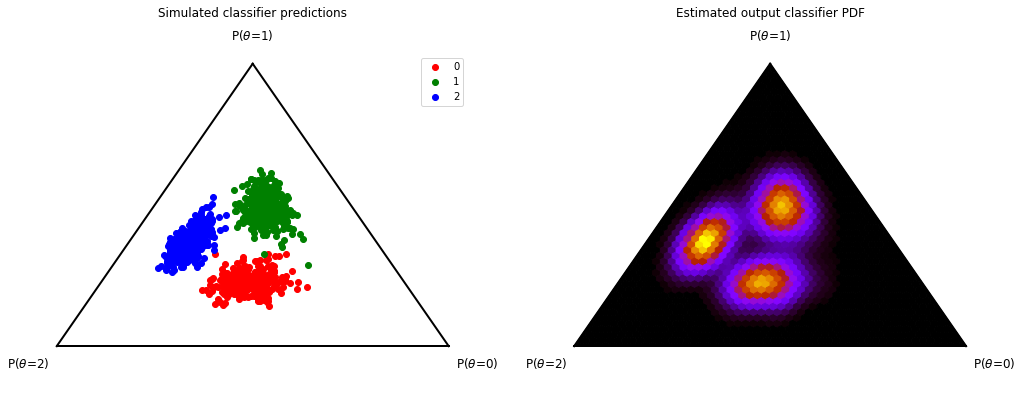

In [11]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
ax_arr[0] = plot_prob_triplex(snt_probs, target=target, ax=ax_arr[0], title='Simulated classifier predictions', fontsize=12);
ax_arr[1] = plot_pdf_triplex(snt_probs, ax=ax_arr[1], title='Estimated output classifier PDF', fontsize=12);
plt.show()

### Apply temperature scaling 

In [12]:
# Temp scaling
T = optim_temperature(snt_logits, target)
temp_probs = softmax(snt_logits/T, axis=1)

nll_temp = neg_log_likelihood(temp_probs, target)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(nll_temp))

Negative log-likelihood after calibration with temp-scaling: 0.532


### Calibrate with PAV extended to multiclass(normalization)

In [13]:
pav_cal = PAVCalibrator(snt_logits, target)

In [14]:
pav_probs = pav_cal.predict(snt_logits)
nll_pav = neg_log_likelihood(pav_probs, target)
print("Negative log-likelihood after calibration with PAV: {:.3f}".format(nll_pav))

Negative log-likelihood after calibration with PAV: 0.334


### Calibrate with NICE flow

In [15]:
nice_calibrator.compile(optimizer='adam', loss='categorical_crossentropy')

Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


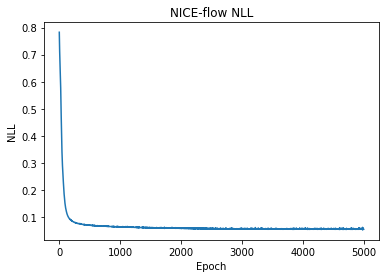

In [16]:
h = nice_calibrator.fit(snt_logits, one_hot, epochs=5000, batch_size=100, verbose=0)

# Plot training NLL
plt.plot(h.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

In [17]:
nice_probs = nice_calibrator.predict(snt_logits, batch_size=100)

nll_nice = neg_log_likelihood(nice_probs, target)

print("Negative log-likelihood after calibration with NICE: {:.3f}".format(nll_nice))

Negative log-likelihood after calibration with NICE: 0.055


### Visualizing results

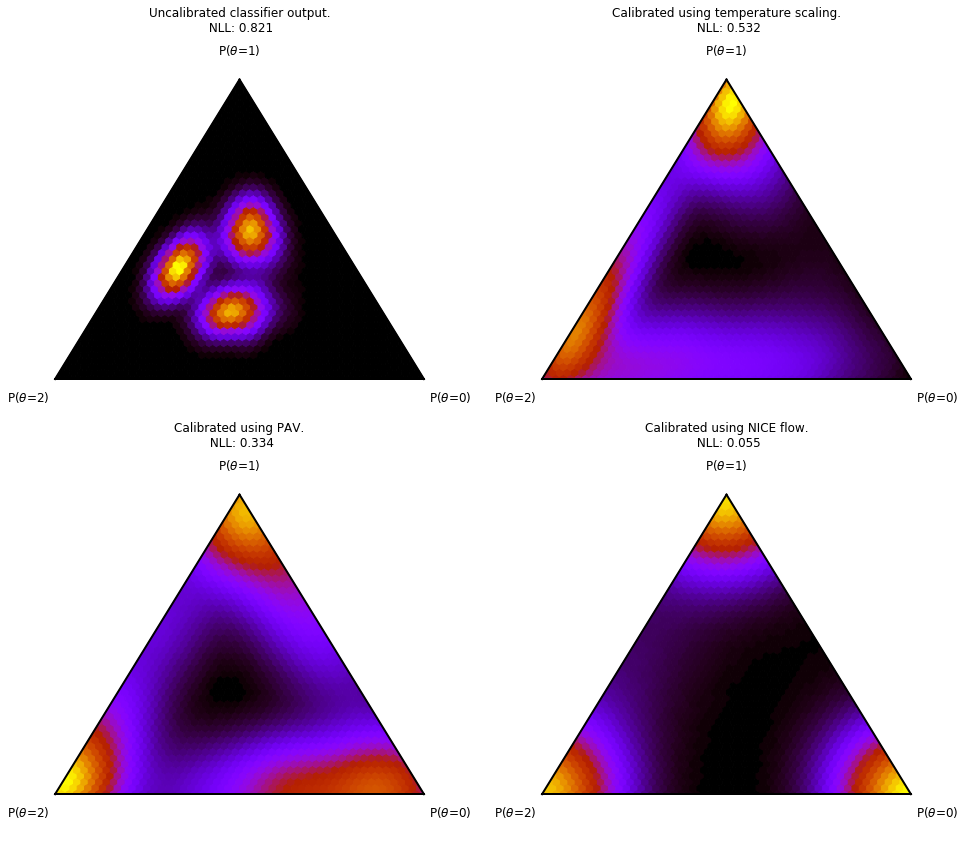

In [18]:
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))
ax_arr[0, 0] = plot_pdf_triplex(snt_probs, ax=ax_arr[0, 0],
                             title='Uncalibrated classifier output.\n NLL: {:.3f}'.format(nll), fontsize=12);
ax_arr[0, 1] = plot_pdf_triplex(temp_probs, ax=ax_arr[0, 1],
                             title='Calibrated using temperature scaling.\n NLL: {:.3f}'.format(nll_temp), fontsize=12);
ax_arr[1, 0] = plot_pdf_triplex(pav_probs, ax=ax_arr[1, 0],
                             title='Calibrated using PAV.\n NLL: {:.3f}'.format(nll_pav), fontsize=12);
ax_arr[1, 1] = plot_pdf_triplex(nice_probs, ax=ax_arr[1, 1],
                             title='Calibrated using NICE flow.\n NLL: {:.3f}'.format(nll_nice), fontsize=12);

plt.show()

## Check that NICE flow is an invertible transformation

In [19]:
# Forward flow
nice_logits = nice_flow.predict(snt_logits, batch_size=100)
# Inverse flow
recons_logits = inv_nice_flow.predict(nice_logits, batch_size=100)

recons_rmse = np.sqrt(np.mean(np.square(snt_logits-recons_logits)))
print("Root mean square reconstrucction error is: {:.3E}".format(recons_rmse))

Root mean square reconstrucction error is: 1.385E-06


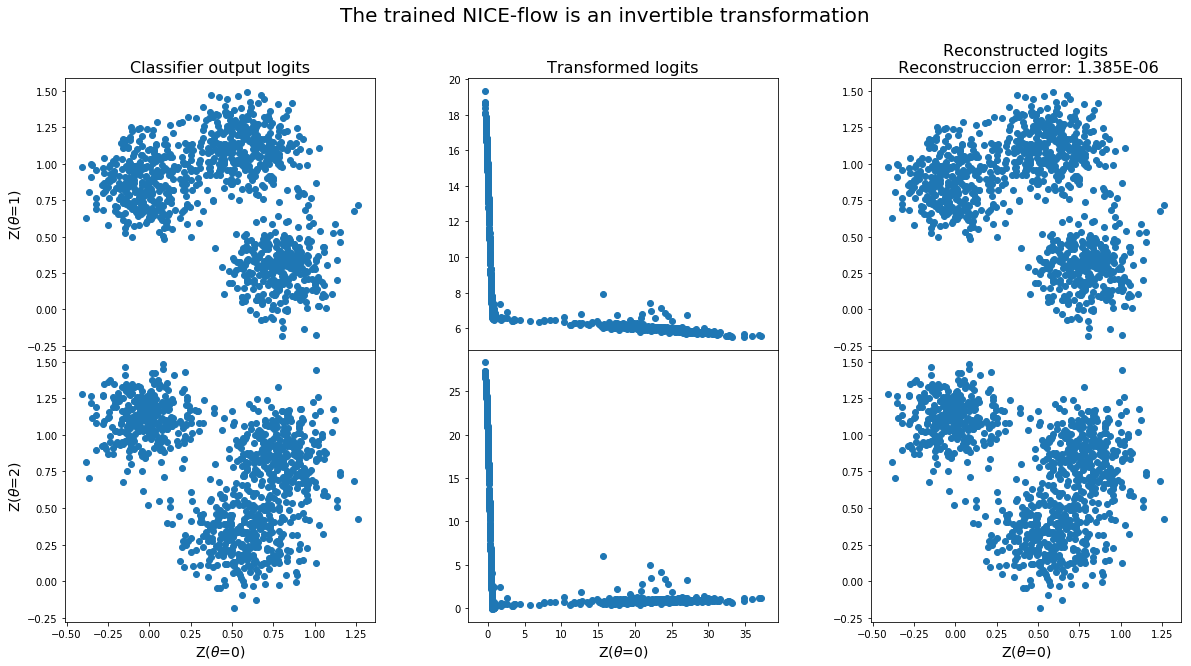

In [20]:
fig, ax_arr = plt.subplots(2, 3, sharex='col', figsize=(20, 10), gridspec_kw={'hspace': 0, 'wspace': 0.3})
fig.suptitle('The trained NICE-flow is an invertible transformation', fontsize=20)

ax_arr[0, 0].scatter(snt_logits[:, 0], snt_logits[:, 1]);
ax_arr[1, 0].scatter(snt_logits[:, 0], snt_logits[:, 2]);

ax_arr[0, 1].scatter(nice_logits[:, 0], nice_logits[:, 1]);
ax_arr[1, 1].scatter(nice_logits[:, 0], nice_logits[:, 2]);

ax_arr[0, 2].scatter(recons_logits[:, 0], recons_logits[:, 1]);
ax_arr[1, 2].scatter(recons_logits[:, 0], recons_logits[:, 2]);

titles = [
    'Classifier output logits', 
    'Transformed logits', 
    'Reconstructed logits\n Reconstruccion error: {:.3E}'.format(recons_rmse)
]
y_labels = ['Z($\\theta$=1)', 'Z($\\theta$=2)']

for ax, title in zip(ax_arr[0], titles):
    ax.set_title(title, fontsize=16)

for ax in ax_arr[-1]:
    ax.set_xlabel('Z($\\theta$=0)', fontsize=14)

for ax, label in zip(ax_arr[:,0], y_labels):
    ax.set_ylabel(label, fontsize=14)

# fig.tight_layout()
plt.show()